In [2]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

os.chdir("/Users/zhongyuanchen/EDA_Customer_Segmentation")
df = pd.read_csv("marketing_campaign.csv",delimiter=';')

In [5]:
df.head().transpose()

,0,1,2,3,4
ID,5524,2174,4141,6182,5324
Year_Birth,1957,1954,1965,1984,1981
Education,Graduation,Graduation,Graduation,Graduation,PhD
Marital_Status,Single,Single,Together,Together,Married
Income,58138.0,46344.0,71613.0,26646.0,58293.0
Kidhome,0,1,0,1,1
Teenhome,0,1,0,0,0
Dt_Customer,2012-09-04,2014-03-08,2013-08-21,2014-02-10,2014-01-19
Recency,58,38,26,26,94
MntWines,635,11,426,11,173


## DATA Cleaning

In [2]:
# Drop null values
num_missing = df.apply( lambda x: any(x.isna()) ,axis=1).sum()
print(f"Number of rows with missing values: {num_missing}") 

# Only 24 columns with missing values, we can apply dropna function to the dataframe
df=df.dropna()

# Drop columns with only one value for all rows
nunique = df.nunique()
cols_to_drop = nunique[nunique == 1].index
df.drop(cols_to_drop, axis=1,inplace=True)

# Drop the ID column as it provides no information for analysis
df.drop("ID",axis=1,inplace=True)

# Drop outliers with Z-Score greater than 5, here we make an exception for #complains
numeric_df = df.select_dtypes(np.number).drop("Complain",axis=1)
filt = abs( stats.zscore(numeric_df,axis=0) )<=5
filt = filt.all(axis=1)
df = df.loc[ filt ]

# Drop columns with only one value for all rows after data cleaning
nunique = df.nunique()
cols_to_drop = nunique[nunique == 1].index
df.drop(cols_to_drop, axis=1,inplace=True)

print("The data is now clean")

Number of rows with missing values: 24
The data is now clean


## Data Transformation

In [3]:
# Numericalize education as years of higher education
df["Years of Higher Education"]=df["Education"].replace( {"Basic":0,"Master":6,"PhD":10,"Graduation":4,"2n Cycle":5} )

# Add age as feature
df["Age"] = 2015-df["Year_Birth"]
df=df.drop("Year_Birth",axis=1)

# Transform and numericalize Marital_Status as single/0 or Together/1
df["Marital_Status"].replace( ['Divorced', 'Widow', 'Alone','Absurd', 'YOLO'],'Single', inplace=True )
df["Numerical_Marital_Status"]=df["Marital_Status"].replace({"Single":0,"Together":1,"Married":1})

# Number of dependencies
df["Num_Dependencies"] = df["Kidhome"]+df["Teenhome"]

# Change the name of columns to be more decriptive
df.columns = [ colname.replace("Mnt","Spend on ") for colname in df.columns]

# Create a feature for total spend
df["Total Spend"] =  df[ [ 'Spend on Wines', 'Spend on Fruits',
       'Spend on MeatProducts', 'Spend on FishProducts',
       'Spend on SweetProducts', 'Spend on GoldProds' ] ].sum(axis=1)

# Drop the categorical columns
to_drop = ["Marital_Status", "Dt_Customer","Education"]
df.drop(to_drop, axis=1,inplace=True)



print(df.dtypes)
print("\nData frame is now all numerical")

Income                       float64
Kidhome                        int64
Teenhome                       int64
Recency                        int64
Spend on Wines                 int64
Spend on Fruits                int64
Spend on MeatProducts          int64
Spend on FishProducts          int64
Spend on SweetProducts         int64
Spend on GoldProds             int64
NumDealsPurchases              int64
NumWebPurchases                int64
NumCatalogPurchases            int64
NumStorePurchases              int64
NumWebVisitsMonth              int64
AcceptedCmp3                   int64
AcceptedCmp4                   int64
AcceptedCmp5                   int64
AcceptedCmp1                   int64
Complain                       int64
Response                       int64
Years of Higher Education      int64
Age                            int64
Numerical_Marital_Status       int64
Num_Dependencies               int64
Total Spend                    int64
dtype: object

Data frame is now all n

## Correlation Analysis

<AxesSubplot:>

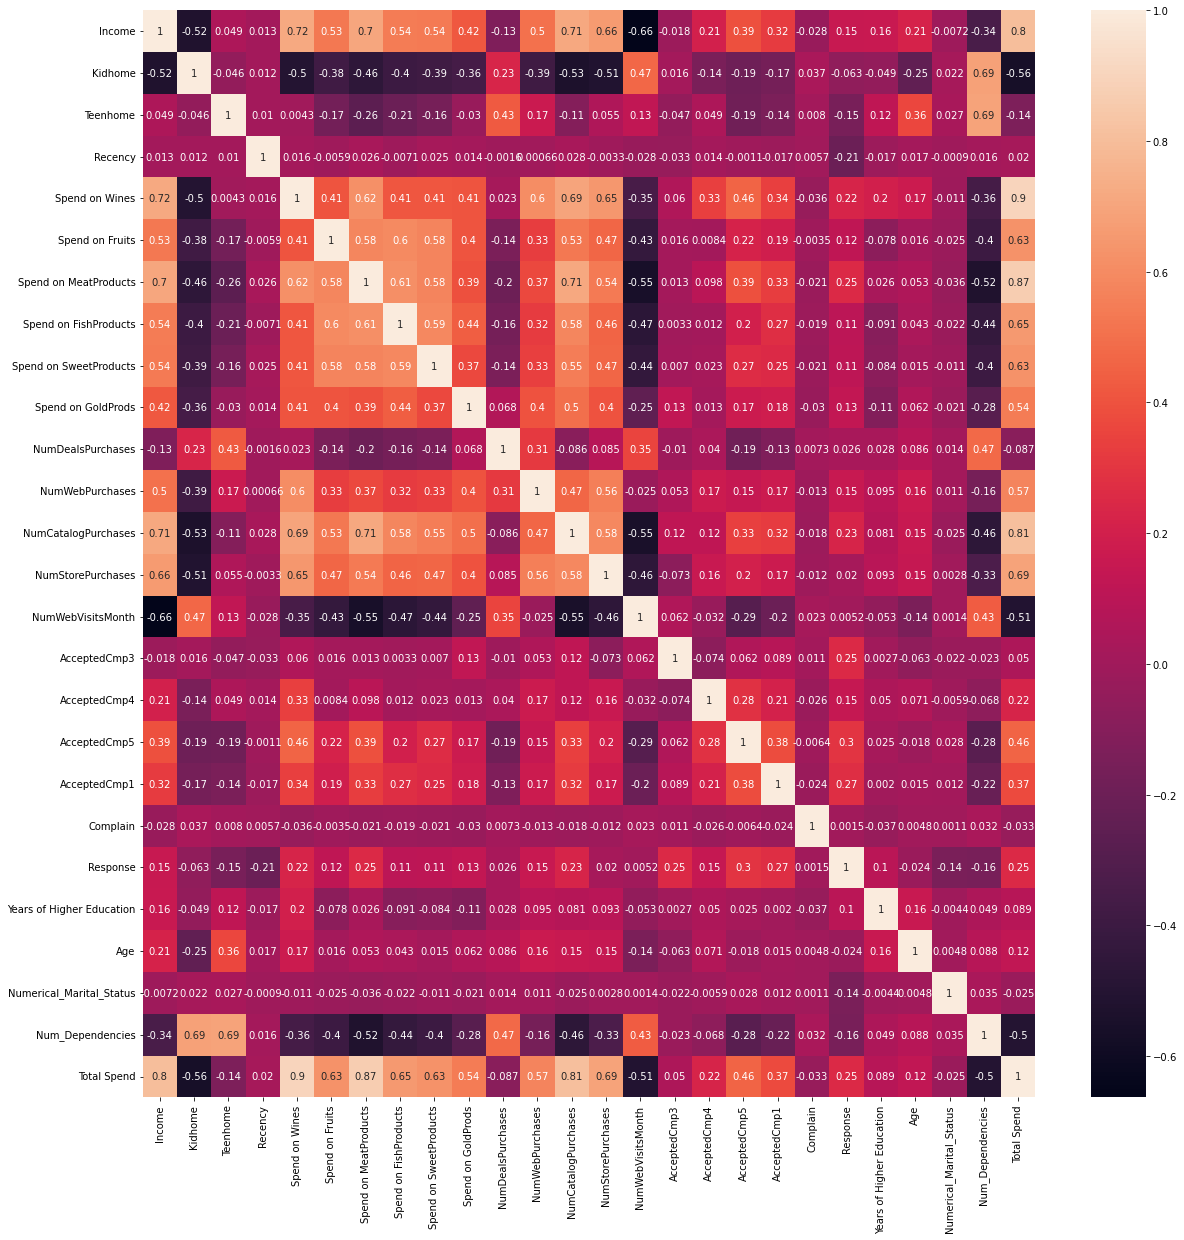

In [4]:
# Calculate the correlation matrix and visualized it as heat map

corr=df.corr()
plt.figure(figsize=(20,20)) 
sns.heatmap(corr,annot=True)

    The visualization above might have too many columns and rows to look at. 
    Bellow, a correlation data frame that is sorted by absolute value of correlation is shown for ease of analysis

In [5]:
# Sort the correlation dataframe for ease of analysis
def zip_sort(x):
    sorted_ser = abs(x).sort_values(ascending=False)
    return pd.Series( zip( sorted_ser.index , x.loc[ sorted_ser.index ] ) )
def Sort_Correlated(corr):
    corr = corr.apply( zip_sort )
    return corr[1:].transpose()

sorted_corr = Sort_Correlated(corr)
sorted_corr

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
Income,"(Total Spend, 0.8036047706566107)","(Spend on Wines, 0.715882978719743)","(NumCatalogPurchases, 0.7099019244424642)","(Spend on MeatProducts, 0.7014182946177069)","(NumWebVisitsMonth, -0.663073017694985)","(NumStorePurchases, 0.6591315636506273)","(Spend on FishProducts, 0.5406215914491233)","(Spend on SweetProducts, 0.5378871707271023)","(Spend on Fruits, 0.5263400450485617)","(Kidhome, -0.5228484504749652)",...,"(Age, 0.2141987490013356)","(AcceptedCmp4, 0.20713358712670502)","(Years of Higher Education, 0.1599403808327332)","(Response, 0.1503967270383608)","(NumDealsPurchases, -0.1275970596460106)","(Teenhome, 0.04879145589676085)","(Complain, -0.027663827090803166)","(AcceptedCmp3, -0.01809316876157871)","(Recency, 0.012500881075176665)","(Numerical_Marital_Status, -0.007210343727599278)"
Kidhome,"(Num_Dependencies, 0.6869343678460531)","(Total Spend, -0.5597274162141495)","(NumCatalogPurchases, -0.5347080518370962)","(Income, -0.5228484504749652)","(NumStorePurchases, -0.5143005101754393)","(Spend on Wines, -0.5018010492487253)","(NumWebVisitsMonth, 0.46952584387300894)","(Spend on MeatProducts, -0.45750667617221336)","(Spend on FishProducts, -0.39706661008014943)","(NumWebPurchases, -0.3885434137762578)",...,"(AcceptedCmp5, -0.1938223715481955)","(AcceptedCmp1, -0.1652393665110356)","(AcceptedCmp4, -0.14343120918930347)","(Response, -0.06261308461192004)","(Years of Higher Education, -0.0492622696123759)","(Teenhome, -0.0461372451206927)","(Complain, 0.03659426552760407)","(Numerical_Marital_Status, 0.02168192653049881)","(AcceptedCmp3, 0.016148171026989868)","(Recency, 0.012434005438442511)"
Teenhome,"(Num_Dependencies, 0.6942523251305438)","(NumDealsPurchases, 0.42748557288524947)","(Age, 0.3633449192913641)","(Spend on MeatProducts, -0.26288400669640993)","(Spend on FishProducts, -0.20500172836029168)","(AcceptedCmp5, -0.1866853954837459)","(Spend on Fruits, -0.17356648176990352)","(NumWebPurchases, 0.16626694674145467)","(Spend on SweetProducts, -0.16255123179188982)","(Response, -0.15240404123820414)",...,"(NumStorePurchases, 0.0551684111127188)","(AcceptedCmp4, 0.04916013440528621)","(Income, 0.04879145589676085)","(AcceptedCmp3, -0.047013356575430494)","(Kidhome, -0.0461372451206927)","(Spend on GoldProds, -0.03030921672478026)","(Numerical_Marital_Status, 0.027075176337821888)","(Recency, 0.01008480002221794)","(Complain, 0.008026011399171825)","(Spend on Wines, 0.004328835595117334)"
Recency,"(Response, -0.2059129430826267)","(AcceptedCmp3, -0.033018462723336126)","(NumWebVisitsMonth, -0.028191053540690594)","(NumCatalogPurchases, 0.027549048547353003)","(Spend on MeatProducts, 0.02633535978017551)","(Spend on SweetProducts, 0.024962303859651952)","(Total Spend, 0.019896516719057625)","(AcceptedCmp1, -0.017363795677822574)","(Age, 0.01715143580071399)","(Years of Higher Education, -0.016865927501144...",...,"(Kidhome, 0.012434005438442511)","(Teenhome, 0.01008480002221794)","(Spend on FishProducts, -0.007058571615442959)","(Spend on Fruits, -0.005875981744683821)","(Complain, 0.005735242102007039)","(NumStorePurchases, -0.0032631692153803813)","(NumDealsPurchases, -0.001614337550674651)","(AcceptedCmp5, -0.0011090343153192764)","(Numerical_Marital_Status, -0.0009006291871613...","(NumWebPurchases, 0.0006591556790231541)"
Spend on Wines,"(Total Spend, 0.9012299910082329)","(Income, 0.715882978719743)","(NumCatalogPurchases, 0.694758477668525)","(NumStorePurchases, 0.6483744015160556)","(Spend on MeatProducts, 0.6215812339841893)","(NumWebPurchases, 0.6046425651180026)","(Kidhome, -0.5018010492487253)","(AcceptedCmp5, 0.45669398069185374)","(Spend on FishProducts, 0.409894826644595)","(Spend on SweetProducts, 0.4098435010062504)",...,"(AcceptedCmp4, 0.334021794461375)","(Response, 0.22418614978695434)","(Years of Higher Education, 0.19840546012563648)","(Age, 0.1703630680787406)","(AcceptedCmp3, 0.0597281625161497)","(Complain, -0.035677648585537215)"

    As we can see, the most correlated feature pairs are expected (i.e. income is positively correlated with total spend etc) 

    However there are a few unexpected correlations like positive correlation between consumption of wine and education, and negative correlation between the number of dependencies and total spend

<AxesSubplot:xlabel='Years of Higher Education', ylabel='Spend on Wines'>

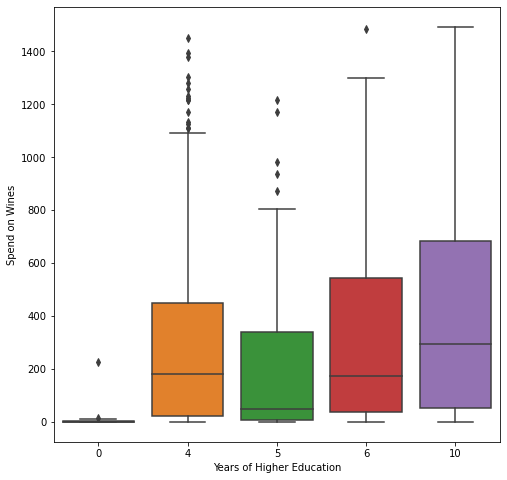

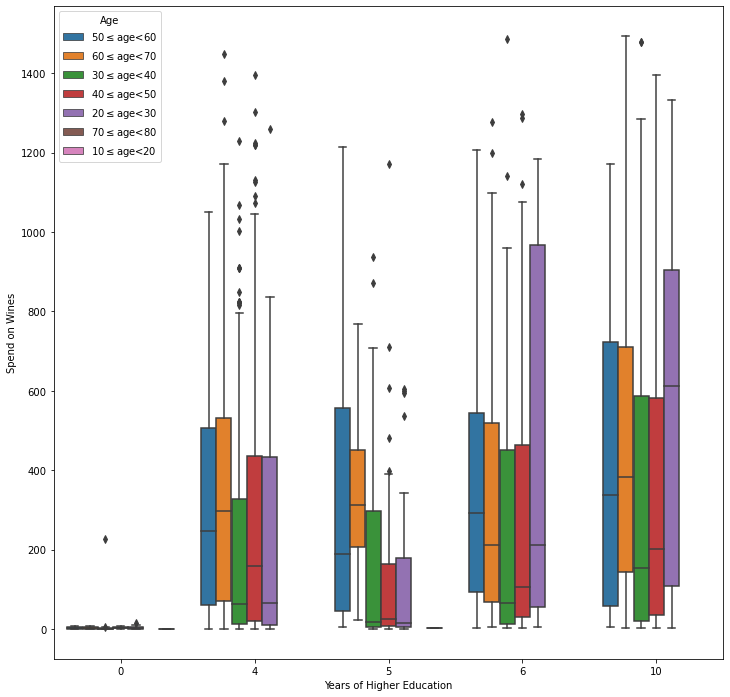

In [7]:
# Create boxplots to investigate the correlation between education and consumption of wine
fig, ax =plt.subplots()
fig.set_size_inches(8,8)
sns.boxplot(x="Years of Higher Education", y="Spend on Wines",data=df,ax=ax)

fig, ax =plt.subplots()
fig.set_size_inches(12,12)
Age_group=df["Age"].apply( lambda x:f"{x//10*10}$\leq$age<{x//10*10+10}" )
sns.boxplot(x="Years of Higher Education", y="Spend on Wines",data=df.loc[ df["Age"] < 70 ] ,hue=Age_group,ax=ax)

    To investigate the correlation between consumption of wines and education, I created a nested boxplot accross different age group. As we can see, the correlation persists across all age groups. This excludes the possibility that the correlation is caused by age while age being slightly correlated with education.

<AxesSubplot:xlabel='Num_Dependencies', ylabel='Income'>

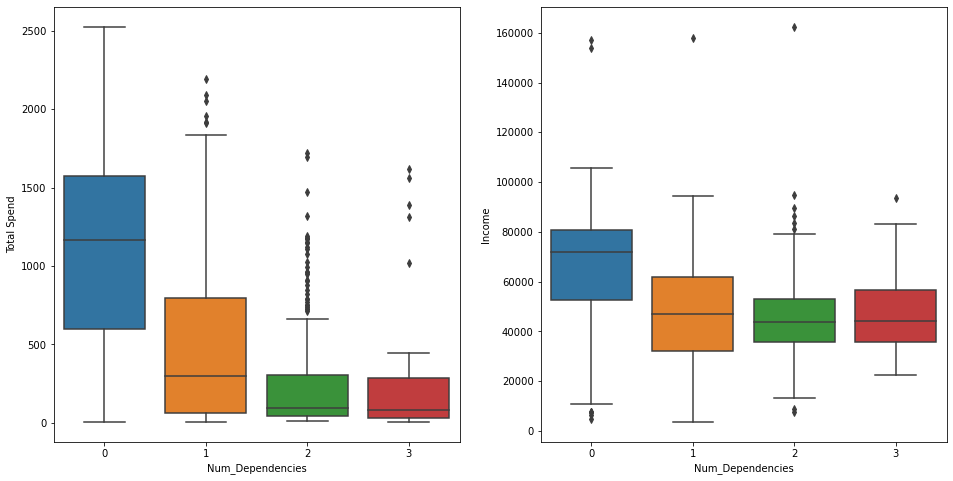

In [8]:
fig, ax =plt.subplots(1,2)
fig.set_size_inches(16,8)
sns.boxplot(y="Total Spend", x="Num_Dependencies",data=df,ax=ax[0])
sns.boxplot(y="Income", x="Num_Dependencies",data=df,ax=ax[1])

    As we can see above, number of dependencies is both negatively correlated with Income and Spend. It is likely that the negative correlation we see between number of dependencies and total spend is caused by the negative correlation between number of dependencies and income which in turn might be caused by education. The key point is that while family with more dependencies is most certainly going to spend more,

## Principal Component Analysis

In [9]:
# Define a charcterstics dataframe for segmentation
char_df=df.copy()
char = ["Income","Years of Higher Education","Age","Num_Dependencies","Kidhome","Teenhome"]
char_df = char_df[char]

# Rescale each feature to have variance 1 for better PCA result
Scaler = StandardScaler()
Scaler.fit(char_df)
scaled_df = pd.DataFrame( Scaler.transform(char_df),columns=char_df.columns )
print("Features sucesfully scaled")

Features sucesfully scaled


In [10]:
# Apply PCA to reduce the dimension of data for Clustering
pca = PCA(n_components=3)
pca.fit(scaled_df)
PCs = pd.DataFrame(pca.components_,columns=char_df.columns)
PCA_df = pd.DataFrame(pca.transform(scaled_df),columns=["1th PC","2th PC","3th PC"])

In [11]:
# Print out principal components and eigenvalues
components = pd.DataFrame(pca.components_,columns = scaled_df.columns,index=["1th PC","2th PC","3th PC"])
components["Eigenvalue"] = pca.explained_variance_
components.T

,1th PC,2th PC,3th PC
Income,-0.433423,0.338572,-0.017291
Years of Higher Education,-0.032867,0.315936,-0.931732
Age,-0.057197,0.563015,0.186502
Num_Dependencies,0.629957,0.240981,0.022961
Kidhome,0.560857,-0.257783,-0.204094
Teenhome,0.310463,0.586553,0.233693
Eigenvalue,2.178968,1.746000,0.930753


## KMeans Clustering

Text(0.5, 1.0, 'Square Lost over Number of Clusters')

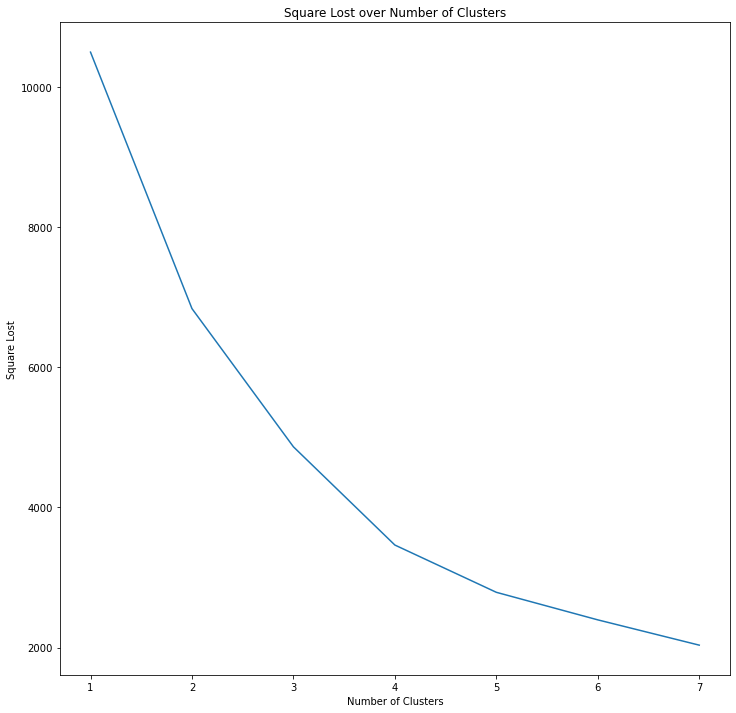

In [12]:
# Apply elbow method
from sklearn.cluster import KMeans
sse = {}
for k in range(1,8):
    KM = KMeans(n_clusters=k,max_iter=1000).fit(PCA_df)
    sse[k]=KM.inertia_
    
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()
ax.plot( list(sse.keys()), list(sse.values()) )
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Square Lost")
ax.set_title("Square Lost over Number of Clusters")

    According to the elbow method, 4 is the optimal number of clusters

In [13]:
## Apply KMeans with 4 clusters
KM = KMeans(n_clusters=4)
# fit model and predict clusters
clusters = KM.fit_predict(PCA_df)
PCA_df["Clusters"] = clusters
# Add the Clusters feature to the orignal dataframe.
df["Clusters"]= clusters

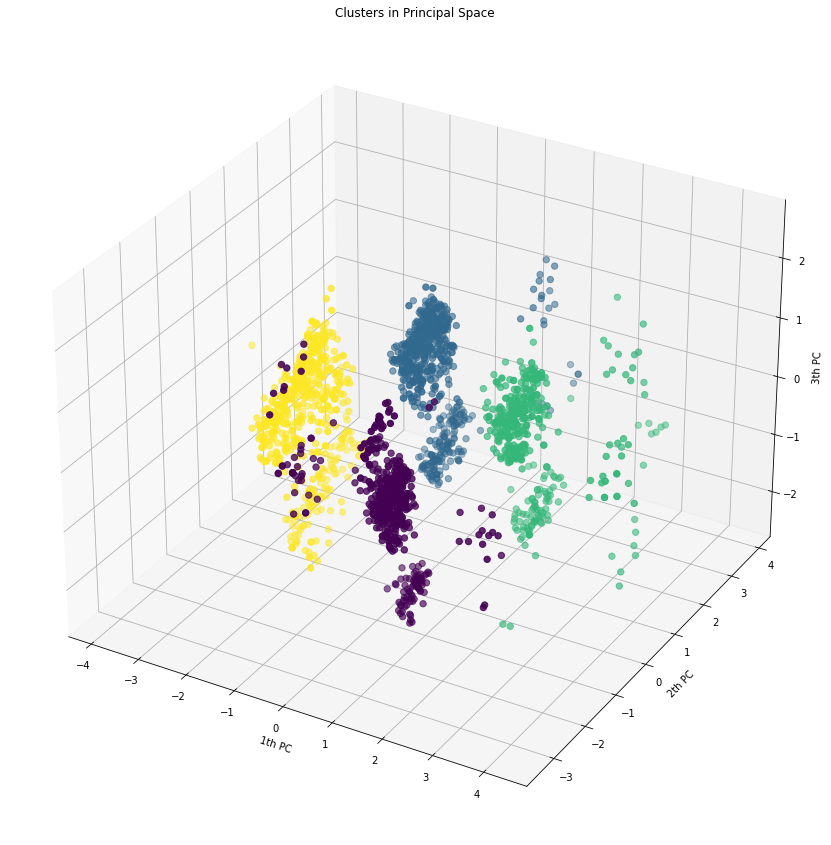

In [14]:
# Scatter plots of clusters in the reduced space
x=PCA_df["1th PC"]
y=PCA_df["2th PC"]
z=PCA_df["3th PC"]

fig = plt.figure(figsize=(15,15))
ax = plt.subplot( projection='3d')
ax.set_xlabel(x.name)
ax.set_ylabel(y.name)
ax.set_zlabel(z.name)
ax.scatter(x, y, z, s=40, c=PCA_df["Clusters"])
ax.set_title("Clusters in Principal Space")
plt.show()

In [15]:
# Show the counts of each cluster
df["Clusters"].value_counts()

1    630
3    569
0    551
2    413
Name: Clusters, dtype: int64

## Customer Segmentation

/Users/zhongyuanchen/opt/anaconda3/envs/Py/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


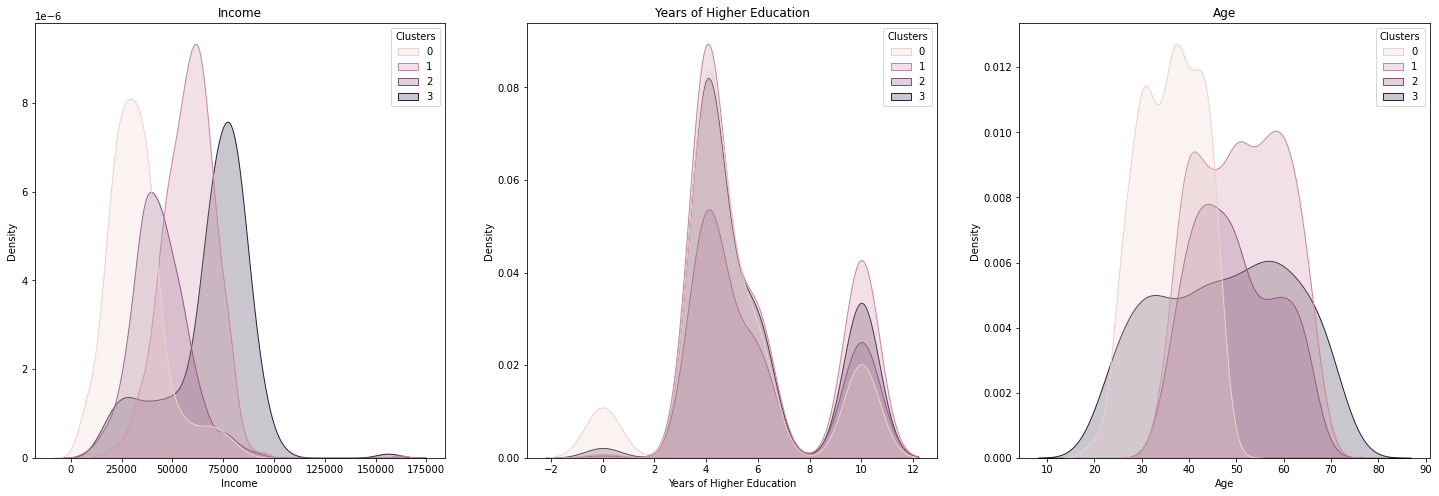

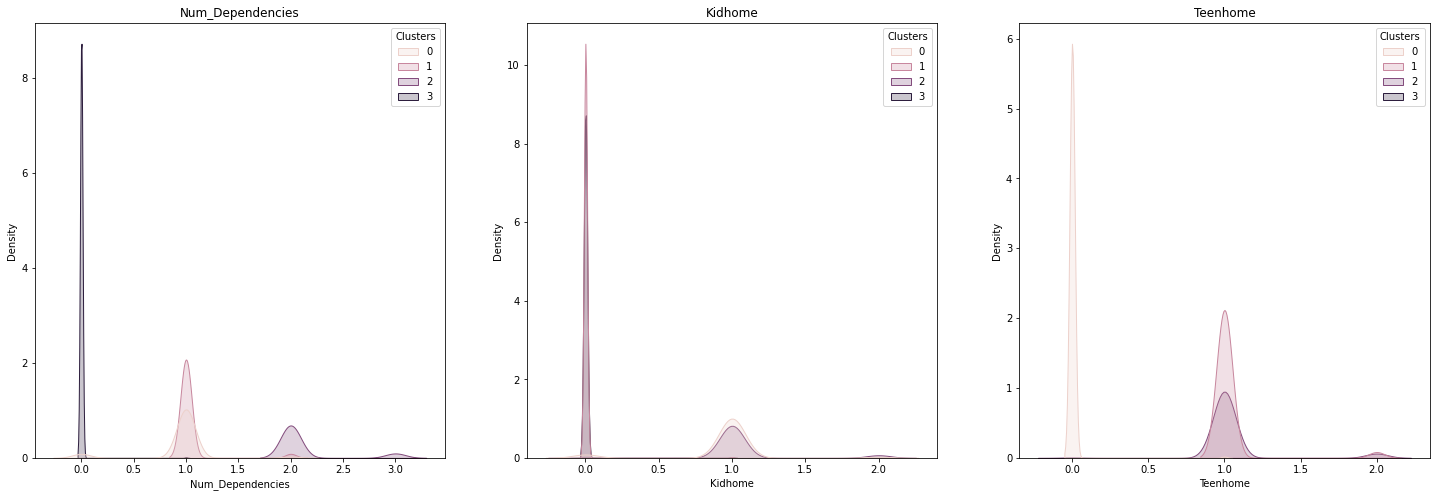

In [16]:
# Explore the charctersitcs of the different groups
i=0
for col in char:
    if i%3==0:
        fig, ax = plt.subplots(1,3)
        fig.set_size_inches(25,8)
    sns.kdeplot(data=df, x=col, hue="Clusters", fill=True,ax=ax[i%3])
    ax[i%3].set_title(col)
    i+=1

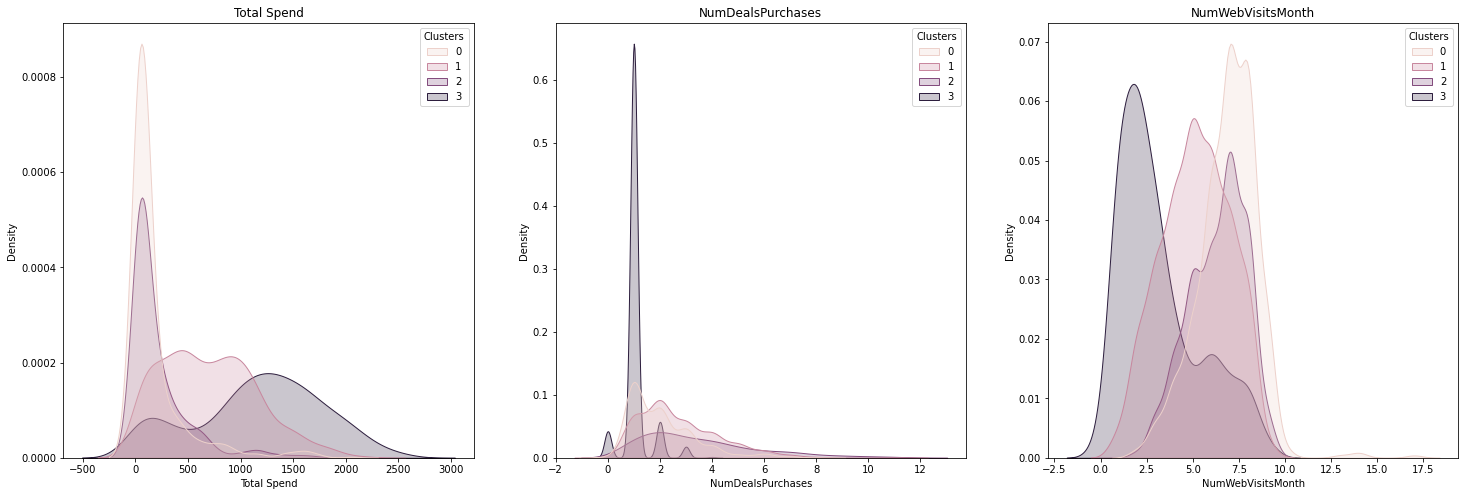

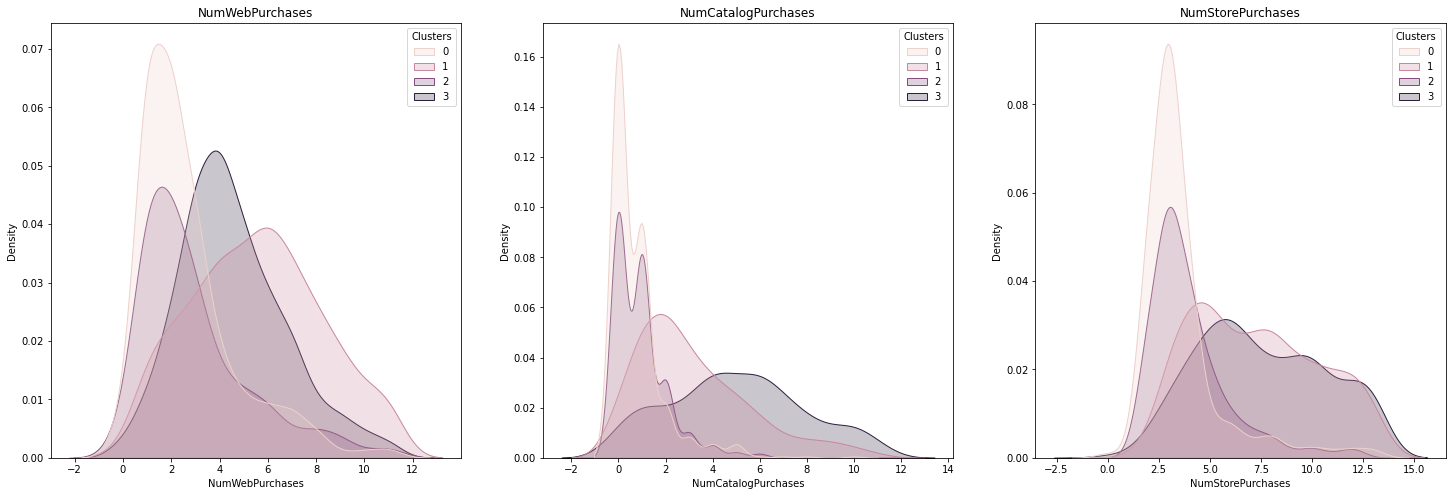

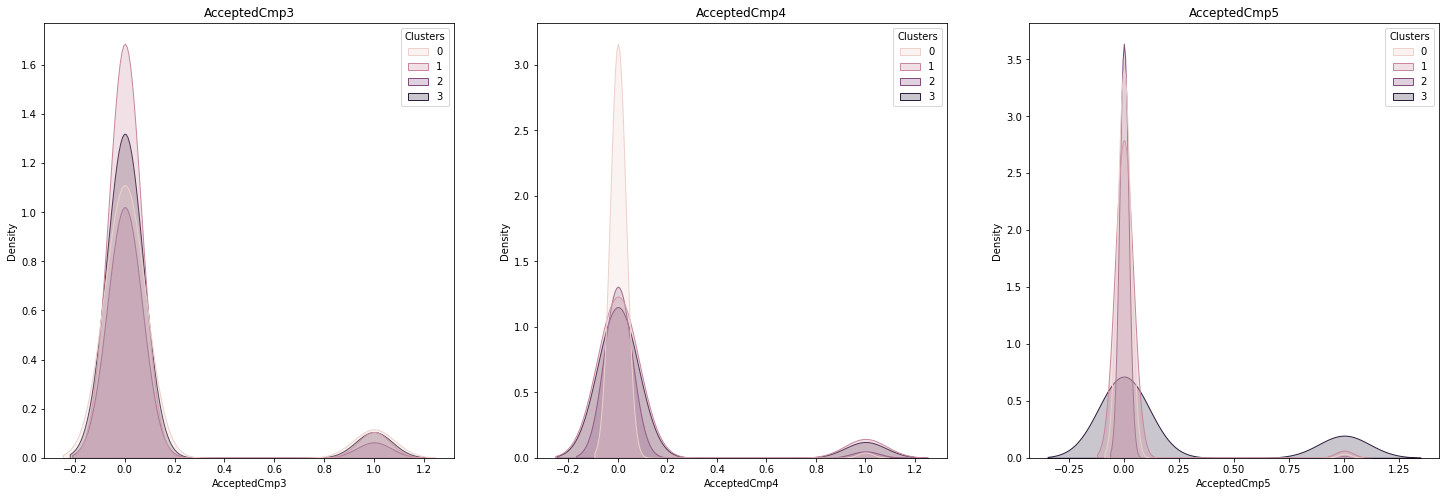

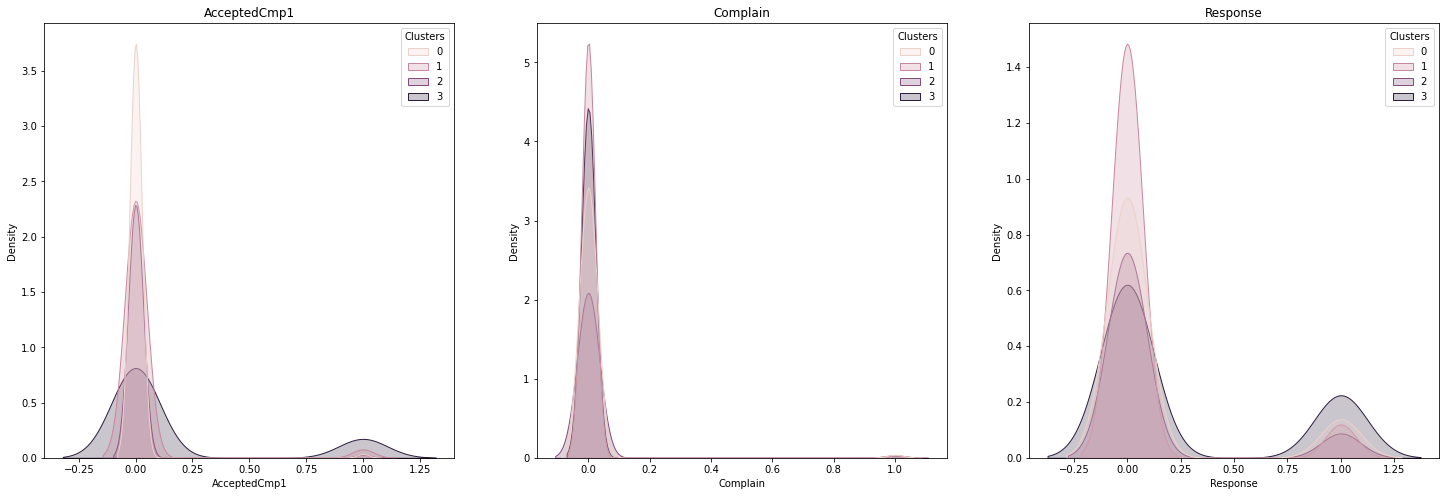

In [17]:
# Explore buying behavior of different groups
behavior = ['Total Spend','NumDealsPurchases', 'NumWebVisitsMonth',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'Complain', 'Response',]
i=0
for col in behavior:
    if i%3==0:
        fig, ax = plt.subplots(1,3)
        fig.set_size_inches(25,8)
    sns.kdeplot(data=df, x=col, hue="Clusters", fill=True,ax=ax[i%3])
    ax[i%3].set_title(col)
    i+=1

    We now make infference from the above plots

## Group 0
    Characteristics:
    
        Mid high income (around 60k)
        
        Have one teenager as dependency
        
        Older

    Buying Behavior:
    
        Average spend
        
        Many website purchases


## Group 1

    Characteristics:

        Low income (around 35k)

        Have one kid as dependency

        Younger

    Buying Behavior:

        Low spend

        Many website visits

        Few website purchases

        Least likely to respond
        
        More store purchases


## Group 2 

    Characteristics:

        High income (around 80k)
        
        Have no dependency
        
        Higher spend

    Buying Behavior:

        Very few deal purchases
        
        Very few website visits
        
        More website purchases
        
        Many catelog Purchases
        
        Most likely to respond


## Group 3
    Characteristics:
    
        Mid low income (around 45k)
        
        Have 2 to 3 dependencies
        
        Middle age

    Buying Behavior:
    
        Low spend
        
        Many website visits
        
        Few website purchases
        
        More Store purchases

## Conclusion

    Knowing the positive correlation between education and wine consumption, sending wine product promotion to the highly educated customers might boost sales
    
    Group 0 (mid high income) and group 2 (high income) should be the target groups for online advertisement as they have low number of website visits but have high number of website purchases
    
    Group 1 (low income) and group 3 (mid low income) despite having higher number of website vistis, they make their purchases mostly in store. Targeting this group with promotions of products that are only avalible in store such as food might attract customers and boost sales.
   